In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/lung_colon_image_set'

# Get the list of files in the directory, excluding .DS_Store
# files = [file for file in os.listdir(data_dir) if not file.startswith('.DS_Store')]

filepaths = []
image_data = []
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/labels120.npy",tr_labels)


Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_dir = "/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Colon Benign Tissue' 'Colon Benign Tissue' 'Colon Benign Tissue' ...
 'Lung adenocarcinoma' 'Lung adenocarcinoma' 'Lung adenocarcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from keras import regularizers
import seaborn as sns

In [ ]:
print(data.shape)

(25099, 120, 120, 3)


In [ ]:
print(labels.shape)

(25099,)


In [ ]:
print(np.unique(labels))

['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']


In [ ]:
classes = np.unique(labels)

## Converting the Target Values to the One-Hot-Encoded Format

In [ ]:
# Initialize the LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the labels
one_hot_encoded_labels = label_binarizer.fit_transform(labels)

# Print the one-hot-encoded labels
print(one_hot_encoded_labels)
one_hot_encoded_labels.shape

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


(25099, 5)

## Visualizing Sample Images

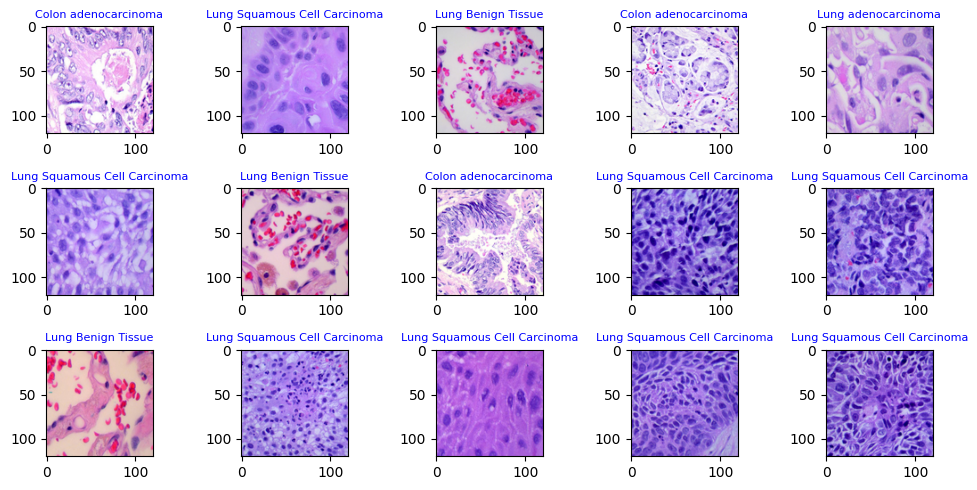

In [ ]:
# Generate random indices
random_indices = np.random.choice(data.shape[0], 15, replace=False)

# Plot randomly selected images in a 5x3 grid
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    # Define subplot in a 5x3 grid
    plt.subplot(3, 5, i + 1)
    # Plot raw pixel data
    plt.imshow(data[idx], cmap=plt.get_cmap('gray'))
    plt.title(labels[idx], color='blue', fontsize=8)

# Adjust layout for better visualization
plt.tight_layout()

# Show the figure
plt.show()

## Visualizing Class Distribution

In [ ]:
# Count the occurrences of unique values
unique_values, counts = np.unique(labels, return_counts=True)

# Display the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} times")

Colon Benign Tissue: 5010 times
Colon adenocarcinoma: 5000 times
Lung Benign Tissue: 5039 times
Lung Squamous Cell Carcinoma: 5040 times
Lung adenocarcinoma: 5010 times


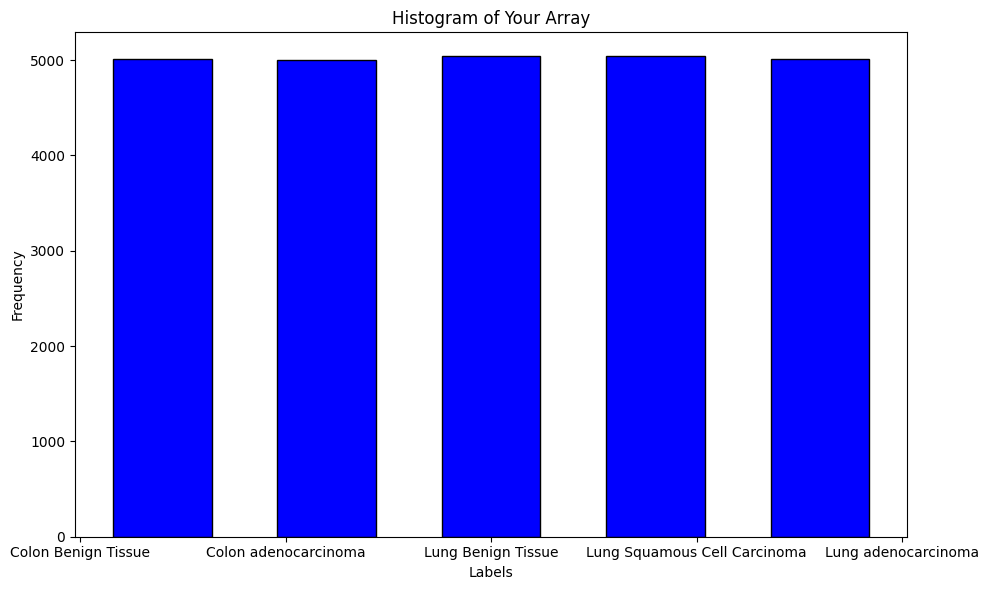

In [ ]:
plt.figure(figsize=(10, 6))
# Plot histogram
plt.hist(labels, bins=5, rwidth = 0.6, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Your Array')

plt.tight_layout()

plt.show()

##Train-Test-Val Split

In [ ]:
# Perform stratified train-test split
X_train, X_temp, y_train, y_temp = train_test_split(data, one_hot_encoded_labels, test_size=0.4, stratify=one_hot_encoded_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the resulting sets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (15059, 120, 120, 3) (15059, 5)
Validation set: (5020, 120, 120, 3) (5020, 5)
Test set: (5020, 120, 120, 3) (5020, 5)


# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [ ]:
## LOSS-ACC GRAPHS
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()


In [ ]:
def confusion_matrix_and_report(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis = 1)
  y_test_classes = np.argmax(y_test, axis = 1)
  conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
  classification_rep = classification_report(y_test_classes, y_pred_classes, target_names = classes)
  print("Confusion Matrix:")
  print(conf_matrix)
  print("\nClassification Report:")
  print(classification_rep)
  plt.figure(figsize=(8,6), facecolor = "lightgray")
  # Create a heatmap for the confusion matrix for better visualisation
  sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "OrRd_r", cbar = False, xticklabels=classes, yticklabels=classes)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show

In [ ]:
#ROC curves
def plot_roc_curve(model, X_test, y_test):
  y_pred_proba = model.predict(X_test)
  for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:,i], y_pred_proba[:,i])
    auc_score = roc_auc_score(y_test[:,i], y_pred_proba[:,i])
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC Curve")
  plt.legend(loc='lower right')
  plt.show()

# Baseline Model

In [ ]:
def build_baseline_model():
  # Create a sequential model
  model = Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(120,120,3), padding='same', strides=(1, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  # Add a Flatten layer to the model
  model.add(Flatten())
  # Add a Dense layer with 128 units and relu activation
  model.add(Dense(128, activation='relu'))
  # Add a Dense layer with 32 units and relu activation
  model.add(Dense(32, activation='relu'))
  # Add the last Dense layer with 5 units for classification (5 classes) and softmax activation
  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss= "categorical_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
model_baseline = build_baseline_model()
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
history_baseline = model_baseline.fit(X_train, y_train, epochs=10, batch_size = 32, validation_data=(X_val, y_val))
test_loss_baseline, test_acc_baseline = model_baseline.evaluate(X_test, y_test)

Epoch 1/10
471/471 [==============================] - 26s 44ms/step - loss: 3.2676 - accuracy: 0.4397 - val_loss: 0.8246 - val_accuracy: 0.6233
Epoch 2/10
471/471 [==============================] - 15s 32ms/step - loss: 0.7831 - accuracy: 0.6267 - val_loss: 1.3064 - val_accuracy: 0.4604
Epoch 3/10
471/471 [==============================] - 15s 33ms/step - loss: 0.6134 - accuracy: 0.6937 - val_loss: 0.6180 - val_accuracy: 0.7070
Epoch 4/10
471/471 [==============================] - 15s 32ms/step - loss: 0.5509 - accuracy: 0.7319 - val_loss: 0.6581 - val_accuracy: 0.7357
Epoch 5/10
471/471 [==============================] - 16s 34ms/step - loss: 0.5219 - accuracy: 0.7544 - val_loss: 0.6662 - val_accuracy: 0.7546
Epoch 6/10
471/471 [==============================] - 15s 32ms/step - loss: 0.4789 - accuracy: 0.7697 - val_loss: 0.7418 - val_accuracy: 0.7159
Epoch 7/10
471/471 [==============================] - 15s 32ms/step - loss: 0.4912 - accuracy: 0.7657 - val_loss: 0.7495 - val_accuracy:

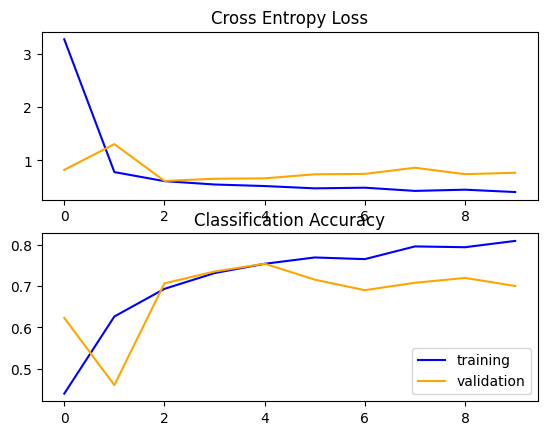

In [ ]:
summarize_diagnostics(history_baseline)

157/157 [==============================] - 1s 7ms/step
Confusion Matrix:
[[337 660   5   0   0]
 [ 47 890   9   4  50]
 [ 14  20 942   1  31]
 [  0   1   0 674 333]
 [  2  29  18 264 689]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.84      0.34      0.48      1002
        Colon adenocarcinoma       0.56      0.89      0.68      1000
          Lung Benign Tissue       0.97      0.93      0.95      1008
Lung Squamous Cell Carcinoma       0.71      0.67      0.69      1008
         Lung adenocarcinoma       0.62      0.69      0.65      1002

                    accuracy                           0.70      5020
                   macro avg       0.74      0.70      0.69      5020
                weighted avg       0.74      0.70      0.69      5020



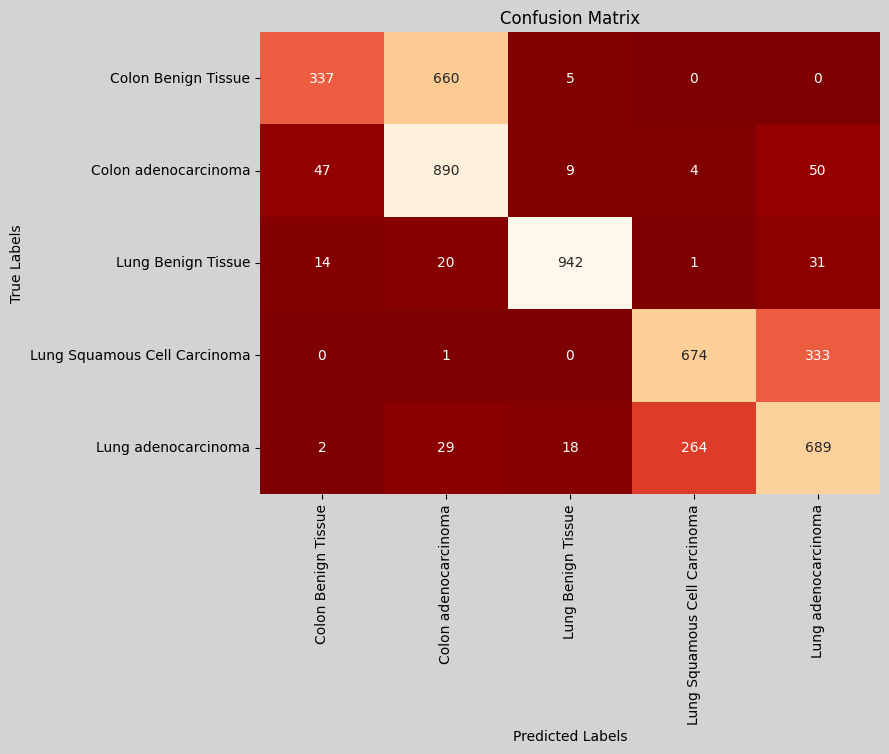

In [ ]:
confusion_matrix_and_report(model_baseline, X_test, y_test)

157/157 [==============================] - 1s 7ms/step
Confusion Matrix:
[[329 667   5   0   1]
 [ 64 875   5   6  50]
 [ 16  23 946   2  21]
 [  0   1   0 691 316]
 [  0  24  25 277 676]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.80      0.33      0.47      1002
        Colon adenocarcinoma       0.55      0.88      0.68      1000
          Lung Benign Tissue       0.96      0.94      0.95      1008
Lung Squamous Cell Carcinoma       0.71      0.69      0.70      1008
         Lung adenocarcinoma       0.64      0.67      0.65      1002

                    accuracy                           0.70      5020
                   macro avg       0.73      0.70      0.69      5020
                weighted avg       0.73      0.70      0.69      5020



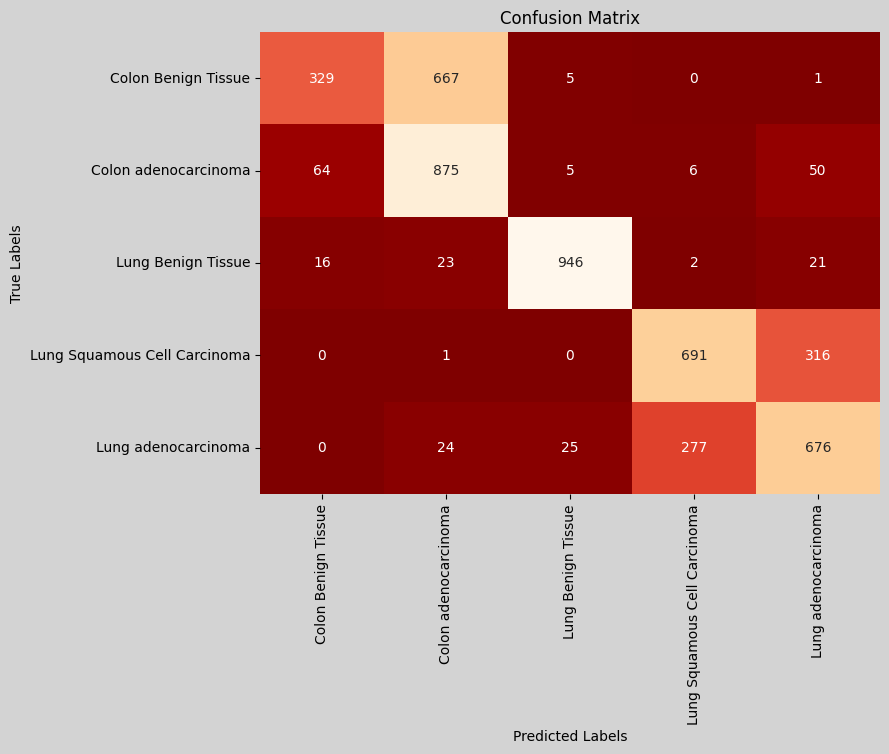

In [ ]:
confusion_matrix_and_report(model_baseline, X_val, y_val)

157/157 [==============================] - 1s 7ms/step


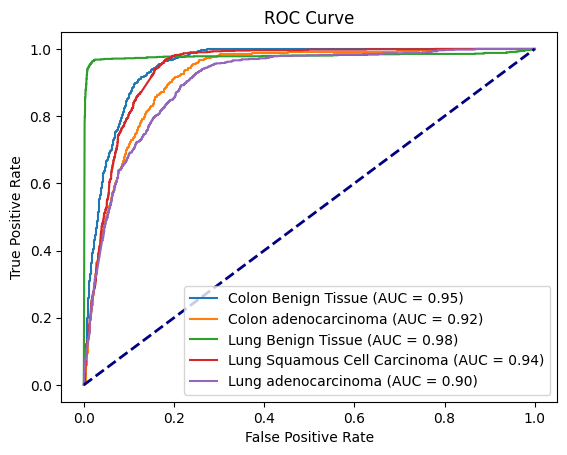

In [ ]:
plot_roc_curve(model_baseline, X_test, y_test)

157/157 [==============================] - 1s 7ms/step


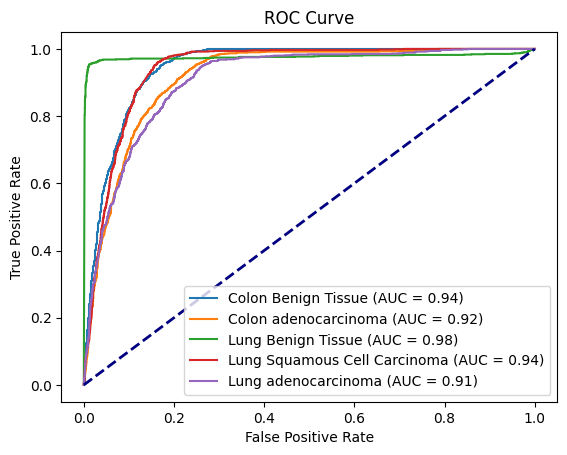

In [ ]:
plot_roc_curve(model_baseline, X_val, y_val)

# Enhanced Model

In [ ]:
def build_enhanced_model():
  # Create a sequential model
  model = Sequential()
  model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(120, 120, 3), padding='same', strides=(1, 1), kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2)))
  # add dropout layers to prevent overfitting
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dense(5, activation='softmax'))
  model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model_enhanced = build_enhanced_model()
model_enhanced.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 256)     7168      
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 128)     295040    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 64)        36928     
                                                      

In [ ]:
history_enhanced = model_enhanced.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))
test_loss_enhanced, test_acc_enhanced = model_enhanced.evaluate(X_test, y_test)

Epoch 1/15
471/471 [==============================] - 93s 195ms/step - loss: 9.1856 - accuracy: 0.3288 - val_loss: 0.8393 - val_accuracy: 0.6614
Epoch 2/15
471/471 [==============================] - 86s 182ms/step - loss: 0.8654 - accuracy: 0.6492 - val_loss: 0.8591 - val_accuracy: 0.6384
Epoch 3/15
471/471 [==============================] - 86s 182ms/step - loss: 0.7111 - accuracy: 0.7240 - val_loss: 0.7679 - val_accuracy: 0.6819
Epoch 4/15
471/471 [==============================] - 86s 182ms/step - loss: 0.6231 - accuracy: 0.7840 - val_loss: 0.4435 - val_accuracy: 0.8655
Epoch 5/15
471/471 [==============================] - 86s 182ms/step - loss: 0.5558 - accuracy: 0.8241 - val_loss: 0.6617 - val_accuracy: 0.7396
Epoch 6/15
471/471 [==============================] - 90s 191ms/step - loss: 0.4938 - accuracy: 0.8611 - val_loss: 0.3243 - val_accuracy: 0.9371
Epoch 7/15
471/471 [==============================] - 86s 182ms/step - loss: 0.4536 - accuracy: 0.8844 - val_loss: 0.4619 - val_ac

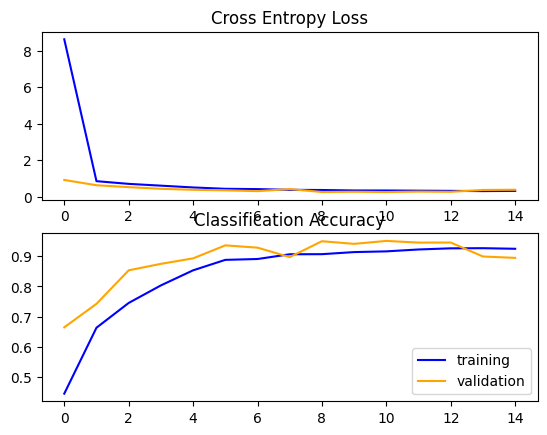

In [ ]:
summarize_diagnostics(history_enhanced)

157/157 [==============================] - 6s 37ms/step
Confusion Matrix:
[[1002    0    0    0    0]
 [  70  929    0    1    0]
 [   2    5  973    0   28]
 [   0    0    0 1007    1]
 [   8    3    6  412  573]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.93      1.00      0.96      1002
        Colon adenocarcinoma       0.99      0.93      0.96      1000
          Lung Benign Tissue       0.99      0.97      0.98      1008
Lung Squamous Cell Carcinoma       0.71      1.00      0.83      1008
         Lung adenocarcinoma       0.95      0.57      0.71      1002

                    accuracy                           0.89      5020
                   macro avg       0.91      0.89      0.89      5020
                weighted avg       0.91      0.89      0.89      5020



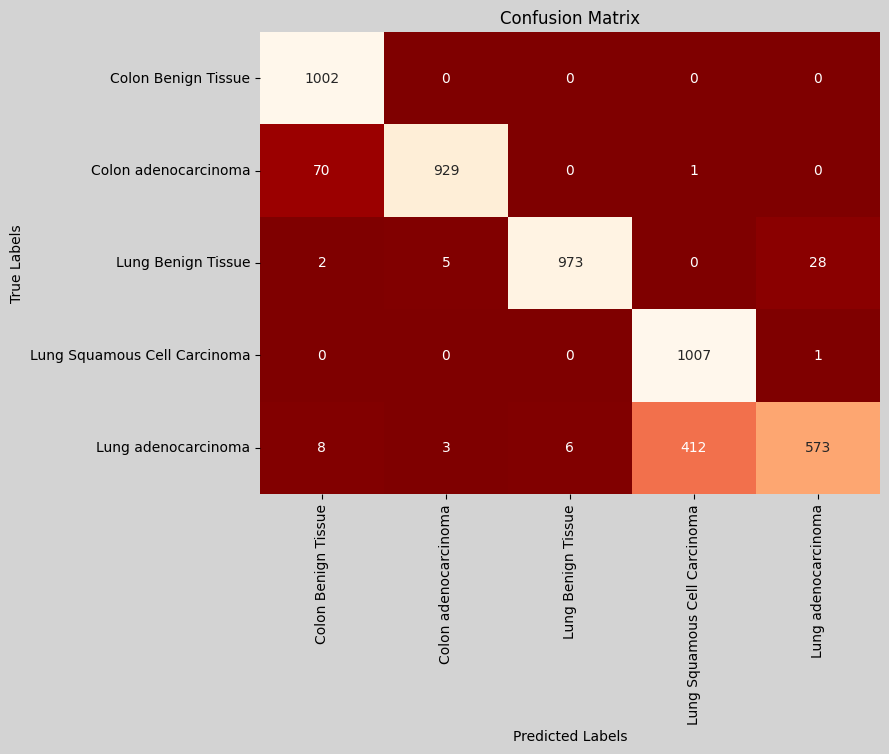

In [ ]:
confusion_matrix_and_report(model_enhanced, X_test, y_test)

157/157 [==============================] - 6s 37ms/step
Confusion Matrix:
[[1002    0    0    0    0]
 [  67  933    0    0    0]
 [   5    1  976    0   26]
 [   0    0    0  997   11]
 [   2    5    4  408  583]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.93      1.00      0.96      1002
        Colon adenocarcinoma       0.99      0.93      0.96      1000
          Lung Benign Tissue       1.00      0.97      0.98      1008
Lung Squamous Cell Carcinoma       0.71      0.99      0.83      1008
         Lung adenocarcinoma       0.94      0.58      0.72      1002

                    accuracy                           0.89      5020
                   macro avg       0.91      0.89      0.89      5020
                weighted avg       0.91      0.89      0.89      5020



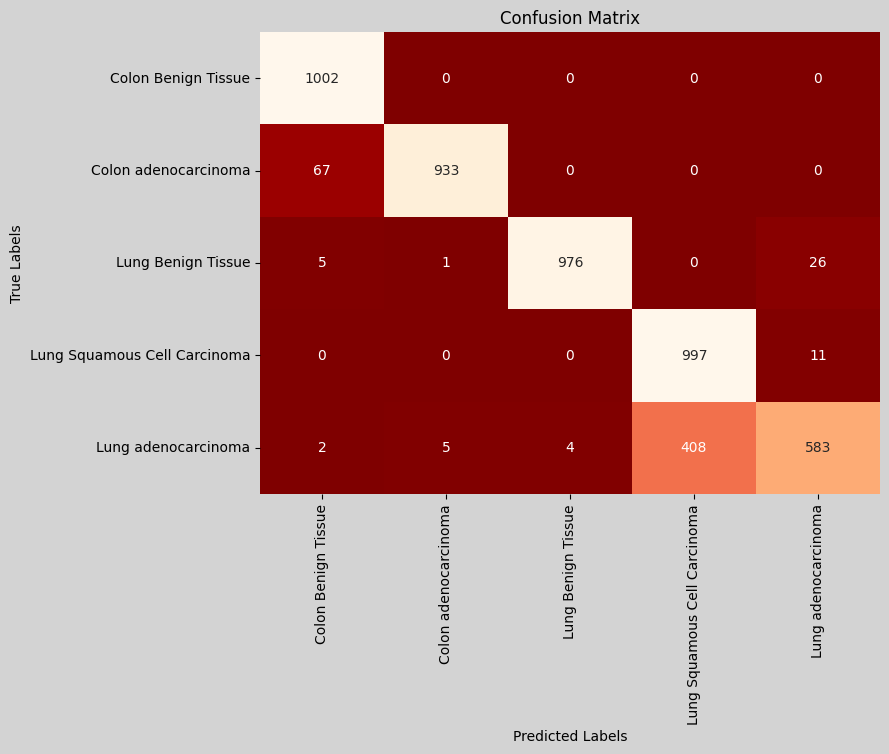

In [ ]:
confusion_matrix_and_report(model_enhanced, X_val, y_val)

157/157 [==============================] - 6s 38ms/step


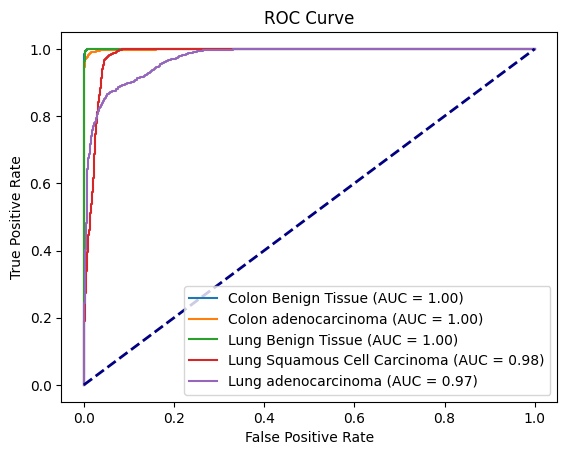

In [ ]:
plot_roc_curve(model_enhanced, X_test, y_test)

157/157 [==============================] - 6s 38ms/step


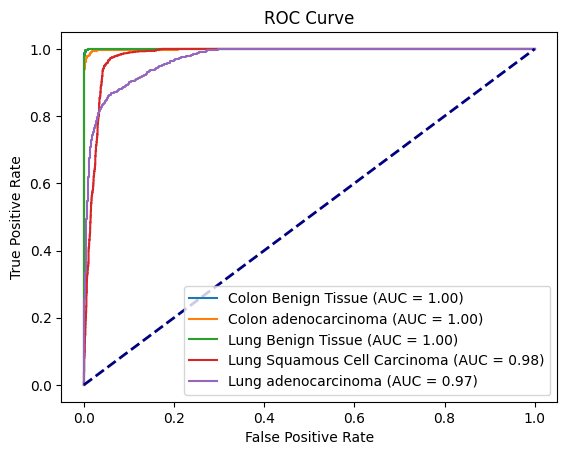

In [ ]:
plot_roc_curve(model_enhanced, X_val, y_val)

# Transfer Learning Model


In [ ]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
vgg_model = VGG16()
# summarize the model
vgg_model.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
from keras.applications.vgg16 import VGG16
# load model without output layer and specify a new input shape for images
vgg_model = VGG16(include_top=False, input_shape=(120, 120, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from keras.models import Model

# add flatten layer
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
# add same Dense layers like in the baseline to get a valid comparison
class1 = layers.Dense(128, activation='relu')(flat1)
class1 = layers.Dense(32, activation='relu')(flat1)
# add output layer with softmax activation
output = layers.Dense(5, activation='softmax')(class1)

# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)

# summarize
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [ ]:
# compile model
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, verbose=1)
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(X_test, y_test)

Epoch 1/15
471/471 [==============================] - 34s 64ms/step - loss: 0.4842 - accuracy: 0.8952 - val_loss: 0.1742 - val_accuracy: 0.9406
Epoch 2/15
471/471 [==============================] - 29s 62ms/step - loss: 0.1058 - accuracy: 0.9618 - val_loss: 0.1549 - val_accuracy: 0.9458
Epoch 3/15
471/471 [==============================] - 26s 54ms/step - loss: 0.0831 - accuracy: 0.9699 - val_loss: 0.1931 - val_accuracy: 0.9504
Epoch 4/15
471/471 [==============================] - 25s 54ms/step - loss: 0.0643 - accuracy: 0.9785 - val_loss: 0.1942 - val_accuracy: 0.9520
Epoch 5/15
471/471 [==============================] - 25s 54ms/step - loss: 0.0547 - accuracy: 0.9812 - val_loss: 0.1273 - val_accuracy: 0.9639
Epoch 6/15
471/471 [==============================] - 25s 54ms/step - loss: 0.0395 - accuracy: 0.9861 - val_loss: 0.1097 - val_accuracy: 0.9707
Epoch 7/15
471/471 [==============================] - 29s 62ms/step - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.1273 - val_accuracy:

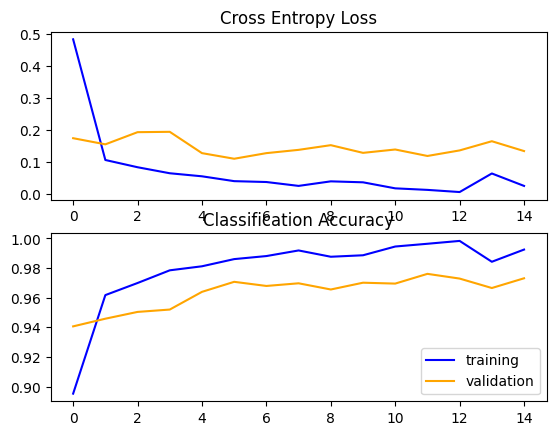

In [ ]:
summarize_diagnostics(history_vgg)

157/157 [==============================] - 6s 40ms/step
Confusion Matrix:
[[ 992    9    0    0    1]
 [   5  968    0    6   21]
 [   1    0 1000    0    7]
 [   0    2    0  981   25]
 [   0   10    4   50  938]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.99      0.99      1002
        Colon adenocarcinoma       0.98      0.97      0.97      1000
          Lung Benign Tissue       1.00      0.99      0.99      1008
Lung Squamous Cell Carcinoma       0.95      0.97      0.96      1008
         Lung adenocarcinoma       0.95      0.94      0.94      1002

                    accuracy                           0.97      5020
                   macro avg       0.97      0.97      0.97      5020
                weighted avg       0.97      0.97      0.97      5020



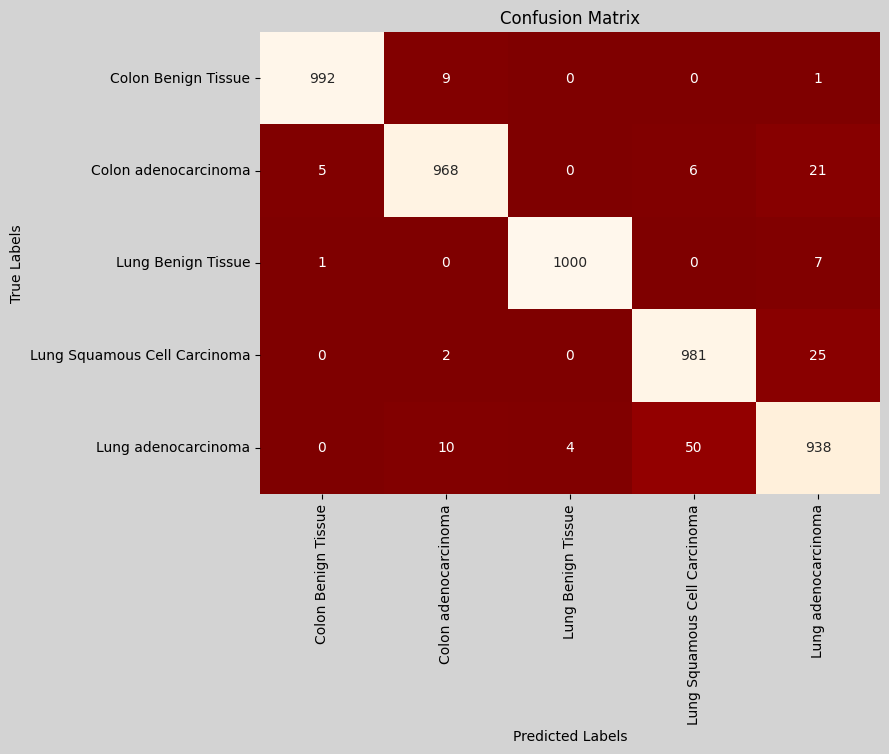

In [ ]:
confusion_matrix_and_report(vgg_model, X_test, y_test)

157/157 [==============================] - 6s 39ms/step
Confusion Matrix:
[[989  13   0   0   0]
 [  6 975   0   7  12]
 [  0   0 999   0   9]
 [  0   3   0 973  32]
 [  0   8   1  44 949]]

Classification Report:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.99      0.99      1002
        Colon adenocarcinoma       0.98      0.97      0.98      1000
          Lung Benign Tissue       1.00      0.99      1.00      1008
Lung Squamous Cell Carcinoma       0.95      0.97      0.96      1008
         Lung adenocarcinoma       0.95      0.95      0.95      1002

                    accuracy                           0.97      5020
                   macro avg       0.97      0.97      0.97      5020
                weighted avg       0.97      0.97      0.97      5020



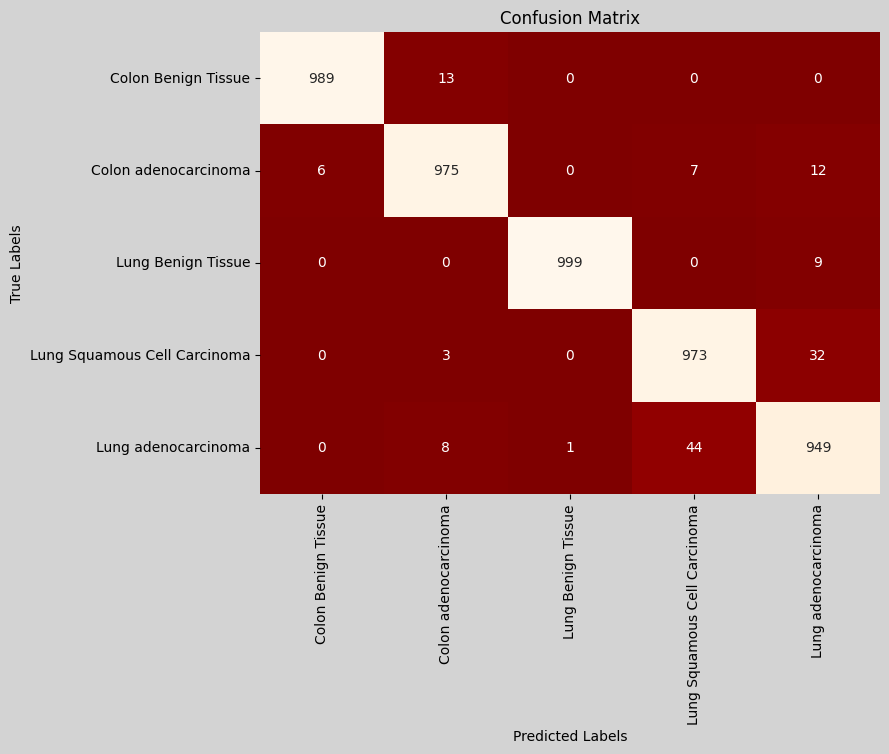

In [ ]:
confusion_matrix_and_report(vgg_model, X_val, y_val)

157/157 [==============================] - 6s 40ms/step


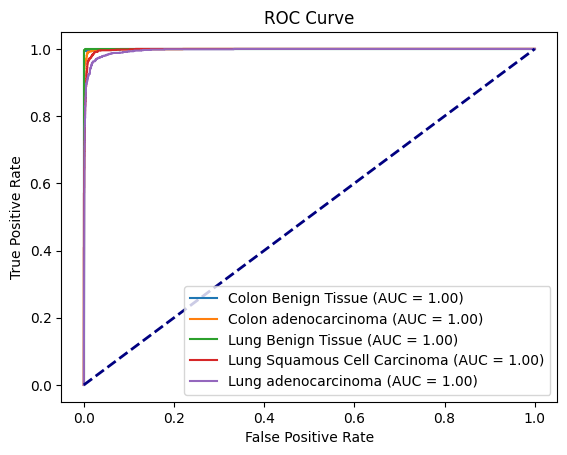

In [ ]:
plot_roc_curve(vgg_model, X_test, y_test)

157/157 [==============================] - 6s 41ms/step


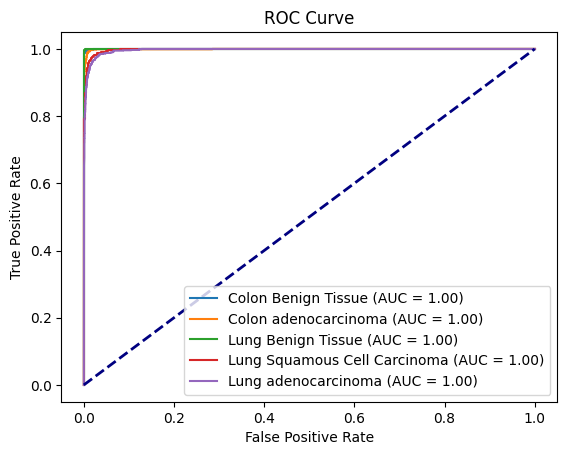

In [ ]:
plot_roc_curve(vgg_model, X_val, y_val)